In [1]:
import pandas as pd
import geojson as gj
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import networkx as nx
import utils

In [2]:
nodes_gdf = gpd.read_file('Scigrid_data/IGGIN_Nodes.geojson')
nodes_gdf.head()

,name,id,country_code,tags,param,method,geometry
0,N_0,NO_N_0,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (6.79720 65.10640)
1,N_1,NO_N_1,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (5.19357 59.33286)
2,N_2,NO_N_2,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89575 60.56023)
3,N_3,NO_N_3,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (2.89614 60.78219)
4,N_4,NO_N_4,NO,{},"{'eic_code': None, 'elevation_m': None, 'exact...","{'eic_code': None, 'elevation_m': None, 'exact...",POINT (3.29837 54.78877)


In [3]:
pipelines_df = utils.get_IGGIN_pipeline_data()
pipelines_df.head()

,id,name,source_id,lat,long,comment,tags,geometry,diameter_mm,end_year,...,method_long_mean,method_max_cap_M_m3_per_d,method_max_pressure_bar,method_num_compressor,method_start_year,method_waterDepth_m,country_code_1,country_code_2,node_id_1,node_id_2
0,INET_PL_1,AlcazarDeSanJuan_Chinchilla,['INET_PL_1'],"[39.3900748, 38.892435]","[-3.3500984, -1.719831]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_23,INET_N_295
1,INET_PL_3,Tarancon_Madrid,['INET_PL_3'],"[40.01, 40.223]","[-3.207, -3.681]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_1460,INET_N_904
2,INET_PL_5,Alessandria_Cortemaggiore,['INET_PL_5'],"[44.991076, 44.90008]","[9.920891, 8.60944]",None,{},None,914.400000,2050,...,make_Attrib(latlong_mean),Lasso,raw,Median,make_Attrib(const),Lasso,IT,IT,INET_N_317,INET_N_26
3,INET_PL_7,Almendralejo_Badajoz,['INET_PL_7'],"[38.711202, 38.87665]","[-6.382539, -6.9714]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_108
4,INET_PL_9,Almendralejo_Zamora,['INET_PL_9'],"[38.711202, 41.506]","[-6.382539, -5.644]",None,{},None,923.792529,2050,...,make_Attrib(latlong_mean),Lasso,Median,Median,make_Attrib(const),Lasso,ES,ES,INET_N_36,INET_N_1653


### Connecting Norwegian grid to the continent

In [4]:
# Dunkerque
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_33', 'node_id_1'] = 'INET_N_407'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_33', 'node_id_2'] = 'INET_N_407'

# Zeebrugge
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_5', 'node_id_1'] = 'INET_N_1656'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_5', 'node_id_2'] = 'INET_N_1656'

# Dornum
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_27', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_27', 'node_id_2'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_1'] == 'Storages_0', 'node_id_1'] = 'INET_N_379'
pipelines_df.loc[pipelines_df['node_id_2'] == 'Storages_0', 'node_id_2'] = 'INET_N_379'

# Emden
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_19', 'node_id_1'] = 'INET_N_436'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_19', 'node_id_2'] = 'INET_N_436'

# Easington
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_39', 'node_id_1'] = 'INET_N_410'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_39', 'node_id_2'] = 'INET_N_410'

# St. Fergus
pipelines_df.loc[pipelines_df['node_id_1'] == 'NO_N_24', 'node_id_1'] = 'INET_N_1401'
pipelines_df.loc[pipelines_df['node_id_2'] == 'NO_N_24', 'node_id_2'] = 'INET_N_1401'

# In the nodes_gdf, drop the rows with the following ids
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_33']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_5']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_27']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_19']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_39']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'NO_N_24']
nodes_gdf = nodes_gdf[nodes_gdf['id'] != 'Storages_0']

### Add attributes (physical properties) to pipelines

In [5]:
# Create a graph of the pipeline network
G = nx.DiGraph()

# Add the nodes to the graph
for i, row in nodes_gdf.iterrows():
    G.add_node(row['id'], pos=(row['geometry'].x, row['geometry'].y), country_code=row['country_code'], is_country_node=False)

# Add the edges to the graph
for i, row in pipelines_df.iterrows():
    if row['node_id_1'] == row['node_id_2']:
        continue
    G.add_edge(row['node_id_1'], row['node_id_2'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_1'],
                                                    country_code_2= row['country_code_2'],
                                                    name= row['name'])
    if row['is_bothDirection']:
        G.add_edge(row['node_id_2'], row['node_id_1'], diameter_mm = row['diameter_mm'], 
                                                   length_km = row['length_km'], 
                                                    capacity= row['max_cap_M_m3_per_d'],
                                                    max_pressure_bar = row['max_pressure_bar'],
                                                    num_compresson = row['num_compressor'],
                                                    water_depth_m = row['waterDepth_m'],
                                                    is_bothDirection = row['is_bothDirection'],
                                                    start_year= row['start_year'],
                                                    end_year= row['end_year'],
                                                    country_code_1= row['country_code_2'],
                                                    country_code_2= row['country_code_1'],
                                                    name= row['name'])

### Add country nodes to the grid

In [6]:
G_with_country_nodes = G.copy()

country_positions = {}

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    country_code = node_data.get('country_code')
    if country_code is not None:
        country_code = str.strip(country_code.upper())
    
    if country_code not in country_positions:
        country_positions[country_code] = []
    country_positions[country_code].append(node_data['pos'])

for country_code, positions in country_positions.items():
    average_position = np.mean(positions, axis=0)
    G_with_country_nodes.add_node(country_code, pos=average_position, is_country_node=True, country_code=country_code)

for node_id, node_data in G_with_country_nodes.nodes(data=True):
    if 'country_node' in node_data:
        G_with_country_nodes.remove_node(node_id)

### Direct dead-end flow from nodes to their respective country nodes 

In [7]:
# Get the list of country nodes
country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]

# Iterate over each node in the graph
for node_id, node_data in G_with_country_nodes.nodes(data=True):
    # Skip country nodes
    if node_data.get('is_country_node'):
        continue
    
    # Get the country code of the node
    country_code = node_data.get('country_code')
    
    # Find the corresponding country super node
    country_super_node = next((cn for cn in country_nodes if G_with_country_nodes.nodes[cn]['country_code'] == country_code), None)
    
    if country_super_node:
        # Check if the node is a sink (only incoming edges)
        if G_with_country_nodes.in_degree(node_id) > 0 and G_with_country_nodes.out_degree(node_id) == 0:
            # Calculate the aggregate in-degree capacity of the child node
            aggregate_in_capacity = sum(G_with_country_nodes.edges[neighbor, node_id]['capacity'] for neighbor in G_with_country_nodes.predecessors(node_id))
            
            # Add an edge directed towards the country node from the node with the aggregate in-degree capacity
            G_with_country_nodes.add_edge(node_id, country_super_node, capacity = aggregate_in_capacity)
        
        
        # Check if the node is a source (only outgoing edges)
        if G_with_country_nodes.in_degree(node_id) == 0 and G_with_country_nodes.out_degree(node_id) > 0:
            # Calculate the aggregate out-degree capacity of the child node
            aggregate_out_capacity = sum(G_with_country_nodes.edges[node_id, neighbor]['capacity'] for neighbor in G_with_country_nodes.successors(node_id))
            
            # Add an edge directed towards the node from the country node with the aggregate out-degree capacity
            G_with_country_nodes.add_edge(country_super_node, node_id, capacity = aggregate_out_capacity) 


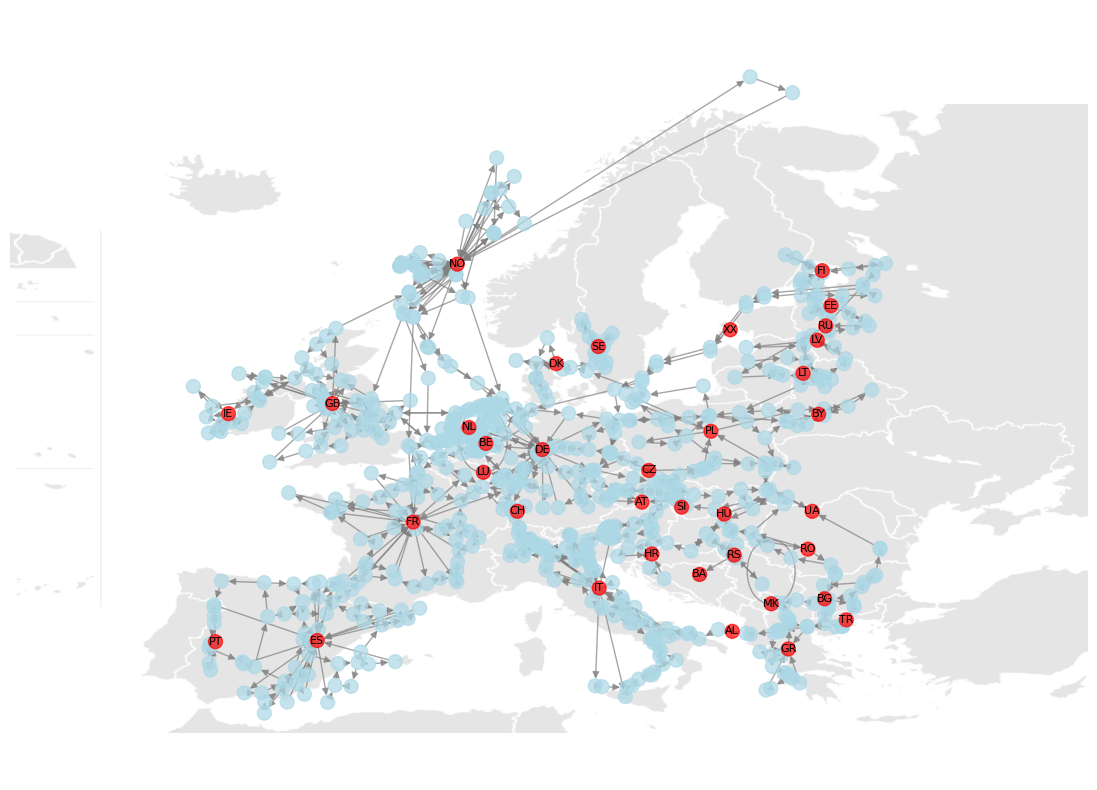

In [8]:
import matplotlib.image as mpimg
europe_map = mpimg.imread('Europe_blank_map.png')

plt.figure(figsize=(15, 10))
plt.imshow(europe_map, extent=[-20, 40, 35, 70], alpha=0.5)

pos = nx.get_node_attributes(G_with_country_nodes, 'pos')
node_colors = ['red' if G_with_country_nodes.nodes[node_id].get('is_country_node') else 'lightblue' for node_id in G_with_country_nodes.nodes]
nx.draw(G_with_country_nodes, pos=pos, with_labels=False, node_size=100, node_color=node_colors, edge_color='gray', width=1, alpha=0.7)

country_nodes = [node_id for node_id, node_data in G_with_country_nodes.nodes(data=True) if node_data.get('is_country_node')]
nx.draw_networkx_labels(G_with_country_nodes, pos=pos, labels={node_id: node_id for node_id in country_nodes}, font_color='black', font_size=8)

plt.show()

### Max flow testing

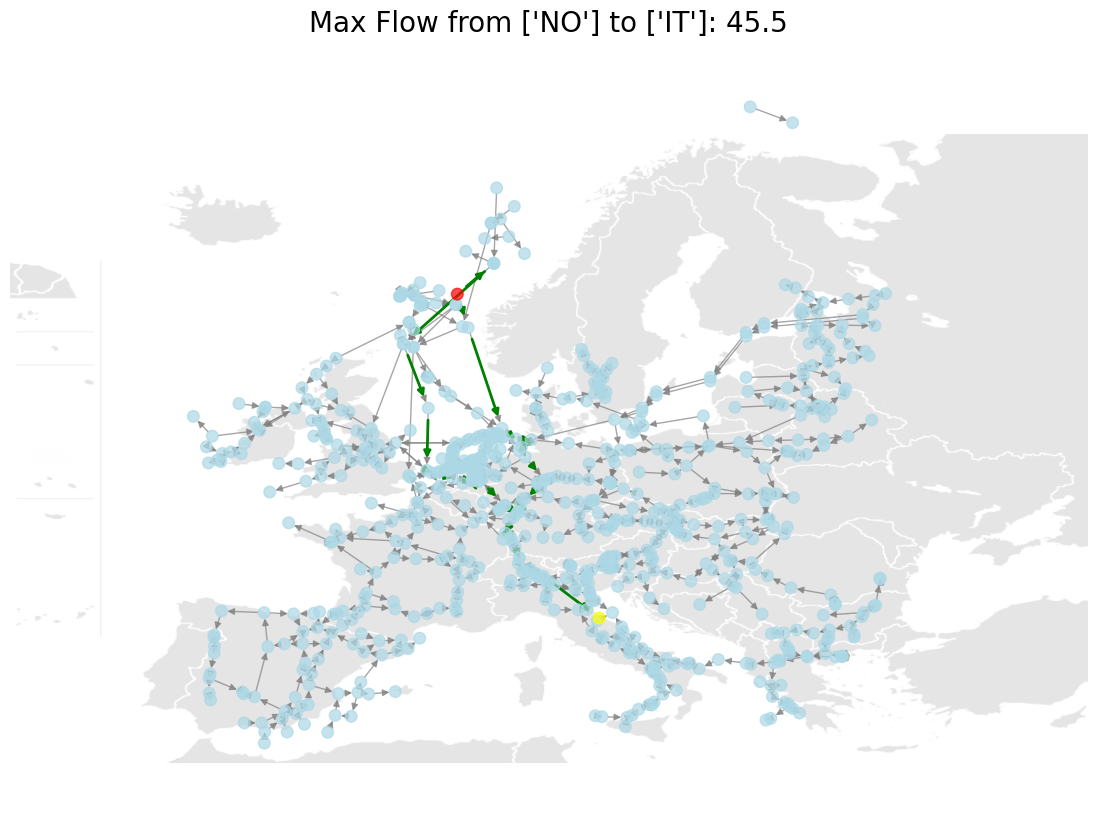

In [9]:
super_sources = ['NO']
super_sinks = ['IT']

flow_val, flow_dict, flow_edges = utils.max_flow(G_with_country_nodes, super_sources, super_sinks)

In [10]:
flow_dict

{'NO_N_0': {'NO_N_1': 0},
 'NO_N_1': {'NO_N_17': 0},
 'NO_N_2': {'NO_N_3': 0},
 'NO_N_3': {'NO': 0},
 'NO_N_4': {'INET_N_1656': 10.441827433601524},
 'NO_N_6': {'NO_N_1': 0},
 'NO_N_7': {'NO_N_8': 0, 'NO_N_25': 0},
 'NO_N_8': {'NO': 0},
 'NO_N_9': {'NO_N_6': 0, 'NO_N_44': 0},
 'NO_N_10': {'NO_N_11': 0},
 'NO_N_11': {'NO': 0},
 'NO_N_12': {'NO_N_13': 0},
 'NO_N_13': {'NO_N_18': 0},
 'NO_N_14': {'NO_N_15': 0},
 'NO_N_15': {'NO': 0},
 'NO_N_16': {'NO_N_4': 10.441827433601524, 'INET_N_410': 0},
 'NO_N_17': {'NO_N_16': 0, 'NO_N_31': 0, 'NO_N_12': 0},
 'NO_N_18': {'INET_N_436': 0},
 'NO_N_20': {'NO_N_21': 0, 'NO_N_11': 0},
 'NO_N_21': {'NO': 0},
 'NO_N_22': {'NO_N_17': 0},
 'NO_N_23': {'NO_N_15': 0},
 'NO_N_25': {'NO_N_16': 0, 'NO_N_17': 0},
 'NO_N_28': {'NO_N_2': 0},
 'NO_N_29': {'NO_N_30': 0},
 'NO_N_30': {'NO': 0},
 'NO_N_31': {'INET_N_379': 0},
 'NO_N_32': {'INET_N_407': 0},
 'NO_N_34': {'NO_N_12': 0},
 'NO_N_35': {'NO_N_25': 0},
 'NO_N_36': {'NO_N_37': 0},
 'NO_N_37': {'NO': 0},
 'NO_N_